<a href="https://colab.research.google.com/github/ydnyshhh/align-drift/blob/main/align_drift_1_SFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip -q uninstall -y wandb
!pip -q install -U --no-cache-dir wandb
import wandb
print("wandb version:", wandb.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 244.2 MB/s eta 0:00:00
wandb version: 0.24.0


In [4]:
import os, re, math, json, random, time
from dataclasses import dataclass, asdict
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
from torch.utils.data import DataLoader

import wandb
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    get_cosine_schedule_with_warmup,
)


In [5]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("gpu:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

torch: 2.9.0+cu126
cuda available: True
gpu: Tesla T4


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [22]:
@dataclass
class CFG:
    model_name: str = "Qwen/Qwen3-0.6B-Base"

    dataset_name: str = "openai/gsm8k"
    dataset_config: str = "main"

    seq_len: int = 512
    train_examples_limit: Optional[int] = None
    eval_examples: int = 256

    # Training knobs
    micro_batch: int = 1
    grad_accum: int = 32
    epochs: int = 2

    lr: float = 1e-5
    weight_decay: float = 0.1
    warmup_ratio: float = 0.03

    eval_every_steps: int = 50
    save_every_steps: int = 100

    seed: int = 42
    output_dir: str = "/content/align-drift-sft"

cfg = CFG()
os.makedirs(cfg.output_dir, exist_ok=True)
set_seed(cfg.seed)

print(json.dumps(asdict(cfg), indent=2))

{
  "model_name": "Qwen/Qwen3-0.6B-Base",
  "dataset_name": "openai/gsm8k",
  "dataset_config": "main",
  "seq_len": 512,
  "train_examples_limit": null,
  "eval_examples": 256,
  "micro_batch": 1,
  "grad_accum": 32,
  "epochs": 2,
  "lr": 1e-05,
  "weight_decay": 0.1,
  "warmup_ratio": 0.03,
  "eval_every_steps": 50,
  "save_every_steps": 100,
  "seed": 42,
  "output_dir": "/content/align-drift-sft"
}


In [7]:
os.environ["WANDB_PROJECT"] = "align-drift-sft"
os.environ["WANDB_WATCH"] = "false"

wandb.login()
run = wandb.init(
    project=os.environ["WANDB_PROJECT"],
    config=asdict(cfg),
    name=f"sft_{cfg.model_name.split('/')[-1]}_seq{cfg.seq_len}_mb{cfg.micro_batch}x{cfg.grad_accum}",
)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yadnyesh (ydnyshhh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
# Dataset Loading

ds = load_dataset(cfg.dataset_name, cfg.dataset_config)
print(ds)

# GSM8K fields: question, answer
full_train = ds["train"]
full_test  = ds["test"]

# Optionally limit train size for quick debugging
if cfg.train_examples_limit is not None:
    full_train = full_train.select(range(min(cfg.train_examples_limit, len(full_train))))


eval_size = min(cfg.eval_examples, len(full_test))
eval_ds = full_test.select(range(eval_size))

print("train:", len(full_train), "eval:", len(eval_ds))
print("sample:", full_train[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1319
    })
})
train: 7473 eval: 256
sample: {'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?', 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}


In [9]:
# Prompt Template

SYSTEM = "You are a helpful assistant that solves math word problems."
PROMPT_TMPL = """System: {system}

User: Solve this problem. Show your reasoning and give the final answer.

Problem:
{question}

Assistant:
"""

def extract_final_answer(gsm8k_answer: str) -> str:
    """
    GSM8K answers typically end with: '#### <number>'
    keep the full chain-of-thought target for SFT, but also store final answer for eval.
    """
    m = re.search(r"####\s*(.*)$", gsm8k_answer.strip())
    return m.group(1).strip() if m else gsm8k_answer.strip()

def format_example(ex: Dict) -> Dict:
    prompt = PROMPT_TMPL.format(system=SYSTEM, question=ex["question"].strip())
    target = ex["answer"].strip()
    final  = extract_final_answer(target)
    return {"prompt": prompt, "target": target, "final": final}

# Apply formatting
train_fmt = full_train.map(format_example, remove_columns=full_train.column_names)
eval_fmt  = eval_ds.map(format_example,  remove_columns=eval_ds.column_names)

print(train_fmt[0]["prompt"][:300])
print(train_fmt[0]["target"][:200])
print("final:", train_fmt[0]["final"])

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

System: You are a helpful assistant that solves math word problems.

User: Solve this problem. Show your reasoning and give the final answer.

Problem:
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April a
Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72
final: 72


In [10]:
# Tokenizer + Model Loading

tokenizer = AutoTokenizer.from_pretrained(
    cfg.model_name,
    use_fast=True,
    trust_remote_code=True,
)

# Ensure pad token exists for batching
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load model in fp16 on GPU
model = AutoModelForCausalLM.from_pretrained(
    cfg.model_name,
    torch_dtype=torch.float16,
    device_map="cuda",
    trust_remote_code=True,
)

model.config.use_cache = False
model.gradient_checkpointing_enable()

print("Loaded:", cfg.model_name)
print("Vocab:", tokenizer.vocab_size, "pad:", tokenizer.pad_token_id, "eos:", tokenizer.eos_token_id)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Loaded: Qwen/Qwen3-0.6B-Base
Vocab: 151643 pad: 151643 eos: 151643


In [11]:
# Pre-Processing for SFT

IGNORE_INDEX = -100

def tokenize_sft_batch(batch: Dict[str, List[str]]) -> Dict[str, List[List[int]]]:
    prompts = batch["prompt"]
    targets = batch["target"]

    # tokenize prompts and targets separately
    tok_p = tokenizer(prompts, add_special_tokens=False)
    tok_t = tokenizer(targets, add_special_tokens=False)

    input_ids, attention_mask, labels = [], [], []

    for p_ids, t_ids in zip(tok_p["input_ids"], tok_t["input_ids"]):
        # Build full sequence: prompt + target + eos
        seq = p_ids + t_ids + [tokenizer.eos_token_id]

        # Truncate to seq_len
        seq = seq[: cfg.seq_len]

        # Labels: -100 for prompt part, supervise target part
        # Compute prompt length after truncation
        p_len = min(len(p_ids), len(seq))
        lab = [IGNORE_INDEX] * p_len + seq[p_len:]
        lab = lab[: cfg.seq_len]

        # Attention mask
        am = [1] * len(seq)

        input_ids.append(seq)
        attention_mask.append(am)
        labels.append(lab)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

# Tokenize datasets
train_tok = train_fmt.map(
    tokenize_sft_batch,
    batched=True,
    remove_columns=train_fmt.column_names,
    desc="Tokenizing train",
)
eval_tok = eval_fmt.map(
    tokenize_sft_batch,
    batched=True,
    remove_columns=eval_fmt.column_names,
    desc="Tokenizing eval",
)

print(train_tok[0].keys())
print("len(input_ids):", len(train_tok[0]["input_ids"]))

Tokenizing train:   0%|          | 0/7473 [00:00<?, ? examples/s]

Tokenizing eval:   0%|          | 0/256 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])
len(input_ids): 131


In [12]:
# Data Collator + Data Loaders

collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

def collate_fn(features: List[Dict]) -> Dict[str, torch.Tensor]:
    # Convert lists to tensors after padding
    batch = collator([{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features])

    # Pad labels manually to match input_ids
    max_len = batch["input_ids"].shape[1]
    padded_labels = []
    for f in features:
        lab = f["labels"]
        if len(lab) < max_len:
            lab = lab + [IGNORE_INDEX] * (max_len - len(lab))
        else:
            lab = lab[:max_len]
        padded_labels.append(lab)

    batch["labels"] = torch.tensor(padded_labels, dtype=torch.long)
    return batch

train_loader = DataLoader(
    train_tok,
    batch_size=cfg.micro_batch,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True,
)

eval_loader = DataLoader(
    eval_tok,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True,
)

# Quick sanity check batch
b = next(iter(train_loader))
print({k: tuple(v.shape) for k, v in b.items()})
print("labels ignore %:", (b["labels"] == IGNORE_INDEX).float().mean().item())

{'input_ids': (1, 276), 'attention_mask': (1, 276), 'labels': (1, 276)}
labels ignore %: 0.5362318754196167


In [15]:
# Optimizer + Scheduler

!pip -q install -U bitsandbytes
import bitsandbytes as bnb
print("bitsandbytes:", bnb.__version__)


import bitsandbytes as bnb
from torch.optim import AdamW

device = "cuda" if torch.cuda.is_available() else "cpu"
model.train()

# 8-bit AdamW (paged) is usually best on Colab T4
optimizer = bnb.optim.PagedAdamW8bit(
    model.parameters(),
    lr=cfg.lr,
    weight_decay=cfg.weight_decay,
)

# Compute training steps
steps_per_epoch = math.ceil(len(train_loader) / cfg.grad_accum)
total_steps = steps_per_epoch * cfg.epochs
warmup_steps = int(total_steps * cfg.warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

print("steps_per_epoch:", steps_per_epoch)
print("total_steps:", total_steps, "warmup_steps:", warmup_steps)

bitsandbytes: 0.49.1
steps_per_epoch: 234
total_steps: 468 warmup_steps: 14


In [16]:
# Loss/Metric Helpers

from contextlib import nullcontext

scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))

def masked_mean(x: torch.Tensor, mask: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    # x, mask: [B, T]
    return (x * mask).sum() / (mask.sum() + eps)

@torch.no_grad()
def eval_nll_ppl(model, loader, max_batches: int = 64):
    """
    Lightweight eval on a few batches: returns avg NLL and perplexity on supervised tokens only.
    """
    model.eval()
    nlls = []
    tok_counts = []
    for i, batch in enumerate(loader):
        if i >= max_batches:
            break
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch)
        # out.loss is mean over all non-ignored labels as implemented by HF
        loss = out.loss.detach().float().item()
        # approximate token count (labels != -100)
        tok = (batch["labels"] != IGNORE_INDEX).sum().item()
        nlls.append(loss * tok)
        tok_counts.append(tok)

    total_tok = max(1, sum(tok_counts))
    avg_nll = sum(nlls) / total_tok
    ppl = float(math.exp(min(20.0, avg_nll)))  # clamp exponent for stability
    model.train()
    return avg_nll, ppl

/tmp/ipython-input-1439317.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))


In [17]:
# Save/Load Checkpoint Utilities

from pathlib import Path

def save_ckpt(step: int):
    ckpt_dir = Path(cfg.output_dir) / f"ckpt_step{step:06d}"
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    model.save_pretrained(str(ckpt_dir), safe_serialization=True)
    tokenizer.save_pretrained(str(ckpt_dir))

    # Save training metadata
    meta = {
        "cfg": asdict(cfg),
        "global_step": step,
        "timestamp": time.time(),
    }
    with open(ckpt_dir / "meta.json", "w") as f:
        json.dump(meta, f, indent=2)

    print("Saved:", ckpt_dir)

def maybe_save(step: int):
    if step == 0 or step % cfg.save_every_steps == 0 or step == total_steps:
        save_ckpt(step)

In [18]:
# Fixed Checkpoint Schedule

ckpt_steps = sorted(set([
    0,
    int(total_steps * 0.25),
    int(total_steps * 0.50),
    total_steps
]))
print("planned checkpoints:", ckpt_steps)

planned checkpoints: [0, 117, 234, 468]


In [23]:
# Training Loop

from tqdm.auto import tqdm
import time, math


device = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = (device == "cuda")

model.train()
optimizer.zero_grad(set_to_none=True)

# Save baseline checkpoint
if 0 in ckpt_steps:
    save_ckpt(0)

global_step = 0
running_tok = 0
t0 = time.time()

pbar = tqdm(total=total_steps, desc="SFT optimizer steps")

for epoch in range(cfg.epochs):
    for batch_idx, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        # supervised token count for throughput stats
        tok = (batch["labels"] != IGNORE_INDEX).sum().item()

        # forward + backward (accumulated)
        with torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16):
            out = model(**batch)
            loss = out.loss / cfg.grad_accum

        loss.backward()
        running_tok += tok

        # optimizer step every grad_accum microbatches
        if (batch_idx + 1) % cfg.grad_accum == 0:
            # clip gradients
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0).item()

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

            global_step += 1
            pbar.update(1)

            # LR logging
            lr = optimizer.param_groups[0].get("lr", float("nan"))

            # throughput
            elapsed = max(1e-6, time.time() - t0)
            toks_per_sec = running_tok / elapsed

            # log train stats
            wandb.log({
                "train/loss": float(out.loss.detach().float().item()),
                "train/lr": float(lr),
                "train/grad_norm": float(grad_norm),
                "train/toks_per_sec": float(toks_per_sec),
                "train/global_step": global_step,
                "train/epoch": epoch + (batch_idx / len(train_loader)),
            }, step=global_step)

            # periodic eval
            if (global_step % cfg.eval_every_steps == 0) or (global_step in ckpt_steps):
                eval_nll, eval_ppl = eval_nll_ppl(model, eval_loader, max_batches=64)
                wandb.log({"eval/nll": float(eval_nll), "eval/ppl": float(eval_ppl)}, step=global_step)
                print(f"\n[step {global_step}] eval_nll={eval_nll:.4f} eval_ppl={eval_ppl:.2f}")

            # checkpoint schedule
            if global_step in ckpt_steps:
                save_ckpt(global_step)

            # reset throughput counters occasionally
            if global_step % 20 == 0:
                running_tok = 0
                t0 = time.time()

            if global_step >= total_steps:
                break

    if global_step >= total_steps:
        break

pbar.close()
print("Training done. Final step:", global_step)

Saved: /content/align-drift-sft/ckpt_step000000


SFT optimizer steps:   0%|          | 0/468 [00:00<?, ?it/s]

/tmp/ipython-input-19684117.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16):



[step 50] eval_nll=0.4706 eval_ppl=1.60

[step 100] eval_nll=0.4555 eval_ppl=1.58

[step 117] eval_nll=0.4533 eval_ppl=1.57
Saved: /content/align-drift-sft/ckpt_step000117

[step 150] eval_nll=0.4516 eval_ppl=1.57

[step 200] eval_nll=0.4456 eval_ppl=1.56

[step 234] eval_nll=0.4441 eval_ppl=1.56
Saved: /content/align-drift-sft/ckpt_step000234

[step 250] eval_nll=0.4446 eval_ppl=1.56

[step 300] eval_nll=0.4444 eval_ppl=1.56

[step 350] eval_nll=0.4444 eval_ppl=1.56

[step 400] eval_nll=0.4442 eval_ppl=1.56

[step 450] eval_nll=0.4443 eval_ppl=1.56
Training done. Final step: 466


In [24]:
# Quick Qualitative Eval

@torch.no_grad()
def generate(model, prompt: str, max_new_tokens: int = 256, temperature: float = 0.7):
    model.eval()
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id,
    )
    text = tokenizer.decode(out[0], skip_special_tokens=True)
    model.train()
    return text

samples = [eval_fmt[i]["prompt"] for i in range(min(5, len(eval_fmt)))]
for i, p in enumerate(samples):
    print("="*80)
    print("PROMPT:\n", p)
    print("\nMODEL:\n", generate(model, p, max_new_tokens=256, temperature=0.7))

PROMPT:
 System: You are a helpful assistant that solves math word problems.

User: Solve this problem. Show your reasoning and give the final answer.

Problem:
Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?

Assistant:


MODEL:
 System: You are a helpful assistant that solves math word problems.

User: Solve this problem. Show your reasoning and give the final answer.

Problem:
Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?

Assistant:
Janet lays 16 eggs per day and eats 3 for breakfast every morning, so she has 16 - 3 = <<16

# Analysis

In [25]:
import os, re, json, math, time
from pathlib import Path
from dataclasses import asdict
from typing import Dict, List, Tuple, Optional

import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

## Paths + checkpoint discovery

In [26]:
BASE_DIR = Path("/content/align-drift-sft")
CKPTS = sorted([p for p in BASE_DIR.glob("ckpt_step*") if p.is_dir()])
print("Found ckpts:", len(CKPTS))
for p in CKPTS[:5]:
    print(" -", p.name)


CKPTS_TO_USE = CKPTS

Found ckpts: 3
 - ckpt_step000000
 - ckpt_step000117
 - ckpt_step000234


In [27]:
SYSTEM = "You are a helpful assistant that solves math word problems."
PROMPT_TMPL = """System: {system}

User: Solve this problem. Show your reasoning and give the final answer.

Problem:
{question}

Assistant:
"""

def extract_final_answer(gsm8k_answer: str) -> str:
    m = re.search(r"####\s*(.*)$", gsm8k_answer.strip())
    return m.group(1).strip() if m else gsm8k_answer.strip()

def format_example(ex: Dict) -> Dict:
    prompt = PROMPT_TMPL.format(system=SYSTEM, question=ex["question"].strip())
    target = ex["answer"].strip()
    final  = extract_final_answer(target)
    return {"prompt": prompt, "target": target, "final": final}

ds = load_dataset("openai/gsm8k", "main")
eval_raw = ds["test"].select(range(200))  # 200 is enough for stable spectra/CKA
eval_fmt = eval_raw.map(format_example, remove_columns=eval_raw.column_names)

print(eval_fmt[0]["prompt"][:250])
print("GT final:", eval_fmt[0]["final"])

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

System: You are a helpful assistant that solves math word problems.

User: Solve this problem. Show your reasoning and give the final answer.

Problem:
Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins fo
GT final: 18


## Representation Capture

Tokenization (same as training)

In [28]:
IGNORE_INDEX = -100
SEQ_LEN = 512

def build_sft_features(tokenizer, ex):
    prompt, target = ex["prompt"], ex["target"]

    tok_p = tokenizer(prompt, add_special_tokens=False)
    tok_t = tokenizer(target, add_special_tokens=False)

    p_ids = tok_p["input_ids"]
    t_ids = tok_t["input_ids"]

    seq = p_ids + t_ids + [tokenizer.eos_token_id]
    seq = seq[:SEQ_LEN]

    p_len = min(len(p_ids), len(seq))
    labels = [IGNORE_INDEX]*p_len + seq[p_len:]
    labels = labels[:SEQ_LEN]
    attn = [1]*len(seq)

    return {"input_ids": seq, "attention_mask": attn, "labels": labels}

def collate_batch(features: List[Dict], pad_id: int):
    max_len = max(len(f["input_ids"]) for f in features)
    input_ids, attn, labels = [], [], []
    for f in features:
        ids = f["input_ids"] + [pad_id]*(max_len - len(f["input_ids"]))
        am  = f["attention_mask"] + [0]*(max_len - len(f["attention_mask"]))
        lab = f["labels"] + [IGNORE_INDEX]*(max_len - len(f["labels"]))
        input_ids.append(ids); attn.append(am); labels.append(lab)

    return {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "attention_mask": torch.tensor(attn, dtype=torch.long),
        "labels": torch.tensor(labels, dtype=torch.long),
    }

Position selection logic

In [29]:
def pick_positions_from_labels(labels_1d: torch.Tensor) -> Dict[str, int]:
    """
    labels_1d: [T], -100 for prompt tokens, >=0 for supervised tokens.
    Returns token indices for last+4pos.
    """
    T = labels_1d.shape[0]
    sup = (labels_1d != IGNORE_INDEX).nonzero(as_tuple=False).flatten()
    if len(sup) == 0:
        # fallback: just last token
        return {"last": T-1}

    first_sup = int(sup[0].item())
    last_sup  = int(sup[-1].item())
    mid_sup   = int(sup[len(sup)//2].item())
    last_prompt = max(0, first_sup - 1)

    return {
        "last_prompt": last_prompt,
        "first_target": first_sup,
        "mid_target": mid_sup,
        "last_target": last_sup,
        "last": T-1,
    }

Random projection

In [35]:
def make_rproj(d_model: int, d_proj: int = 256, seed: int = 0) -> torch.Tensor:
    g = torch.Generator(device="cpu")
    g.manual_seed(seed)
    # Gaussian random projection (Johnson–Lindenstrauss)
    R = torch.randn(d_model, d_proj, generator=g) / math.sqrt(d_proj)
    return R

def apply_rproj(X: torch.Tensor, R: torch.Tensor) -> torch.Tensor:
    # X: [..., d_model] (often fp16), R: [d_model, d_proj] (fp32)
    Xf = X.float()
    Rf = R.to(device=X.device, dtype=torch.float32)
    return Xf @ Rf

Collect reps for one checkpoint

In [36]:
@torch.no_grad()
def collect_reps_for_ckpt(
    ckpt_dir: Path,
    tokenizer,
    eval_fmt,
    batch_size: int = 1,
    d_proj: int = 256,
    device: str = "cuda",
    max_examples: Optional[int] = None,
    rproj_seed: int = 0,
):
    model = AutoModelForCausalLM.from_pretrained(
        str(ckpt_dir),
        torch_dtype=torch.float16,
        device_map=device,
        trust_remote_code=True,
    )
    model.config.use_cache = False
    model.eval()

    # Build a small batchable feature list
    N = len(eval_fmt) if max_examples is None else min(max_examples, len(eval_fmt))
    feats = [build_sft_features(tokenizer, eval_fmt[i]) for i in range(N)]

    # Peek d_model + layers by doing one forward
    b0 = collate_batch([feats[0]], tokenizer.pad_token_id)
    b0 = {k: v.to(device) for k, v in b0.items()}
    out0 = model(**b0, output_hidden_states=True)
    hidden0 = out0.hidden_states  # tuple: (emb, layer1,...,layerL)
    L = len(hidden0) - 1
    d_model = hidden0[1].shape[-1]
    print(f"[{ckpt_dir.name}] layers={L} d_model={d_model} N={N}")

    R = make_rproj(d_model, d_proj=d_proj, seed=rproj_seed)

    # store on CPU to avoid VRAM blowups
    pos_names = ["last_prompt", "first_target", "mid_target", "last_target", "last"]
    reps = [ [] for _ in range(L) ]  # each element gets [N, P, d_proj] chunks

    for i in range(0, N, batch_size):
        batch_feats = feats[i:i+batch_size]
        batch = collate_batch(batch_feats, tokenizer.pad_token_id)
        batch = {k: v.to(device) for k, v in batch.items()}

        out = model(**batch, output_hidden_states=True)
        hs = out.hidden_states  # (emb, layer1..L)
        labels = batch["labels"]

        # positions per item
        pos_idx = []
        for b in range(labels.shape[0]):
            pos = pick_positions_from_labels(labels[b])
            pos_idx.append([pos[n] for n in pos_names])
        pos_idx = torch.tensor(pos_idx, device=device)  # [B, P]

        # collect layerwise
        for layer in range(1, L+1):
            H = hs[layer]  # [B, T, d_model]
            # gather positions -> [B, P, d_model]
            B, T, D = H.shape
            gather = H.gather(
                dim=1,
                index=pos_idx.unsqueeze(-1).expand(B, pos_idx.shape[1], D)
            )
            proj = apply_rproj(gather, R).float().cpu().numpy()  # [B,P,d_proj]
            reps[layer-1].append(proj)

    reps = [np.concatenate(chunks, axis=0) for chunks in reps]  # list of [N,P,d_proj]
    return {"reps": reps, "pos_names": pos_names}

Run representation capture for all checkpoints

In [37]:
def save_reps_npz(save_path: Path, reps_obj: Dict, ckpt_name: str):
    save_path.parent.mkdir(parents=True, exist_ok=True)
    arr = np.stack(reps_obj["reps"], axis=0)  # [L, N, P, d]
    np.savez_compressed(
        save_path,
        reps=arr,
        pos_names=np.array(reps_obj["pos_names"], dtype=object),
        ckpt=np.array([ckpt_name], dtype=object),
    )
    print("saved", save_path, "shape", arr.shape)

# Load tokenizer from any checkpoint
tokenizer = AutoTokenizer.from_pretrained(str(CKPTS_TO_USE[0]), use_fast=True, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

REP_DIR = BASE_DIR / "analysis_reps"
REP_DIR.mkdir(exist_ok=True)

for ckpt in CKPTS_TO_USE:
    out_path = REP_DIR / f"{ckpt.name}_reps.npz"
    if out_path.exists():
        print("skip exists:", out_path.name)
        continue
    obj = collect_reps_for_ckpt(ckpt, tokenizer, eval_fmt, batch_size=1, d_proj=256, device="cuda", max_examples=200)
    save_reps_npz(out_path, obj, ckpt.name)

The tokenizer you are loading from '/content/align-drift-sft/ckpt_step000000' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


[ckpt_step000000] layers=28 d_model=1024 N=200
saved /content/align-drift-sft/analysis_reps/ckpt_step000000_reps.npz shape (28, 200, 5, 256)
[ckpt_step000117] layers=28 d_model=1024 N=200
saved /content/align-drift-sft/analysis_reps/ckpt_step000117_reps.npz shape (28, 200, 5, 256)
[ckpt_step000234] layers=28 d_model=1024 N=200
saved /content/align-drift-sft/analysis_reps/ckpt_step000234_reps.npz shape (28, 200, 5, 256)


# Core Metrics: CKA, Spectra, RankMe, α-ReQ

### Load reps

In [38]:
def load_reps(path: Path):
    z = np.load(path, allow_pickle=True)
    reps = z["reps"]  # [L,N,P,d]
    pos_names = list(z["pos_names"])
    ckpt = str(z["ckpt"][0])
    return reps, pos_names, ckpt

rep_files = sorted(REP_DIR.glob("*_reps.npz"))
print("rep files:", len(rep_files))
base_reps, pos_names, base_name = load_reps(rep_files[0])
print("base:", base_name, "shape:", base_reps.shape, "pos:", pos_names)

rep files: 3
base: ckpt_step000000 shape: (28, 200, 5, 256) pos: ['last_prompt', 'first_target', 'mid_target', 'last_target', 'last']


### CKA implementation: Linear CKA (centered)

In [39]:
def center(X: np.ndarray) -> np.ndarray:
    # X: [N, d]
    return X - X.mean(axis=0, keepdims=True)

def linear_cka(X: np.ndarray, Y: np.ndarray, eps: float = 1e-12) -> float:
    """
    CKA = ||Y^T X||_F^2 / (||X^T X||_F * ||Y^T Y||_F)
    X, Y: [N, d]
    """
    X = center(X); Y = center(Y)
    XT_X = X.T @ X
    YT_Y = Y.T @ Y
    YT_X = Y.T @ X
    num = np.sum(YT_X**2)
    den = math.sqrt(np.sum(XT_X**2) * np.sum(YT_Y**2) + eps)
    return float(num / (den + eps))

### Layerwise CKA curve (base vs each ckpt)

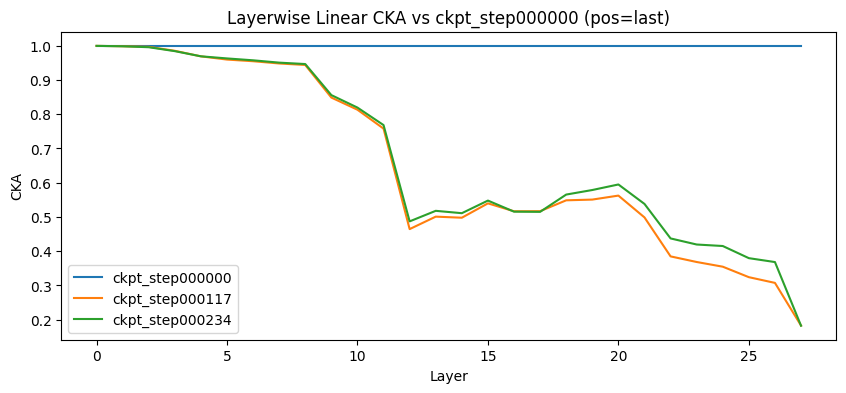

In [40]:
def layerwise_cka_curve(base: np.ndarray, other: np.ndarray, pos_idx: int) -> np.ndarray:
    # base/other: [L,N,P,d]
    L = base.shape[0]
    out = np.zeros(L, dtype=np.float32)
    for l in range(L):
        X = base[l, :, pos_idx, :]
        Y = other[l, :, pos_idx, :]
        out[l] = linear_cka(X, Y)
    return out

pos_to_use = pos_names.index("last")  # most efficient default
cka_curves = {}

for f in rep_files:
    reps, _, ckpt = load_reps(f)
    cka_curves[ckpt] = layerwise_cka_curve(base_reps, reps, pos_to_use)

# Plot
plt.figure(figsize=(10,4))
for ckpt, curve in cka_curves.items():
    plt.plot(curve, label=ckpt)
plt.title(f"Layerwise Linear CKA vs {base_name} (pos={pos_names[pos_to_use]})")
plt.xlabel("Layer")
plt.ylabel("CKA")
plt.legend()
plt.show()

### Cross-layer CKA heatmap (base layers vs SFT layers)

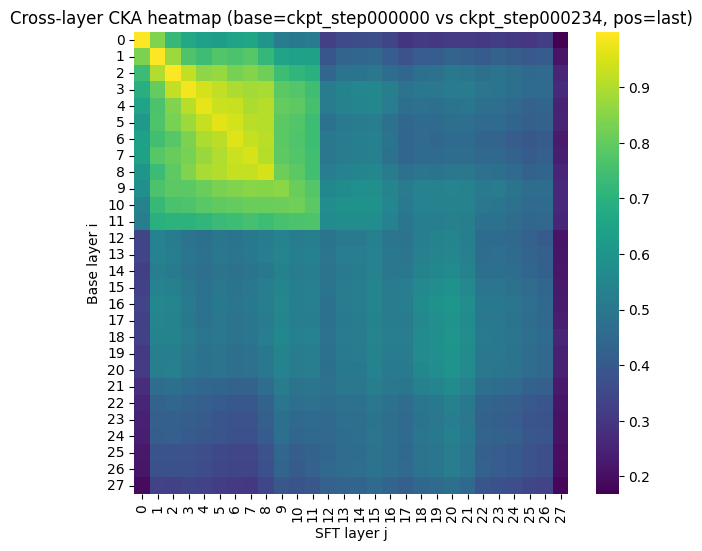

In [41]:
def cross_layer_cka(base: np.ndarray, other: np.ndarray, pos_idx: int) -> np.ndarray:
    L = base.shape[0]
    M = np.zeros((L, L), dtype=np.float32)
    for i in range(L):
        X = base[i, :, pos_idx, :]
        for j in range(L):
            Y = other[j, :, pos_idx, :]
            M[i, j] = linear_cka(X, Y)
    return M

final_reps, _, final_name = load_reps(rep_files[-1])
M = cross_layer_cka(base_reps, final_reps, pos_to_use)

plt.figure(figsize=(7,6))
sns.heatmap(M, cmap="viridis")
plt.title(f"Cross-layer CKA heatmap (base={base_name} vs {final_name}, pos={pos_names[pos_to_use]})")
plt.xlabel("SFT layer j")
plt.ylabel("Base layer i")
plt.show()

## Spectral + RankMe + α-ReQ

### Spectrum + effective rank

In [42]:
def singular_values(X: np.ndarray) -> np.ndarray:
    # X: [N,d] -> svdvals of centered X
    Xc = center(X).astype(np.float32)
    # Use SVD on CPU
    s = np.linalg.svd(Xc, full_matrices=False, compute_uv=False)
    return s

def effective_rank_from_singulars(s: np.ndarray, eps: float = 1e-12) -> float:
    p = s / (np.sum(s) + eps)
    H = -np.sum(p * np.log(p + eps))
    return float(np.exp(H))

def renyi_effective_rank(s: np.ndarray, alpha: float, eps: float = 1e-12) -> float:
    p = s / (np.sum(s) + eps)
    if abs(alpha - 1.0) < 1e-6:
        return effective_rank_from_singulars(s, eps=eps)
    H_a = (1.0/(1.0-alpha)) * np.log(np.sum((p + eps)**alpha) + eps)
    return float(np.exp(H_a))

### Layerwise effective rank across checkpoints

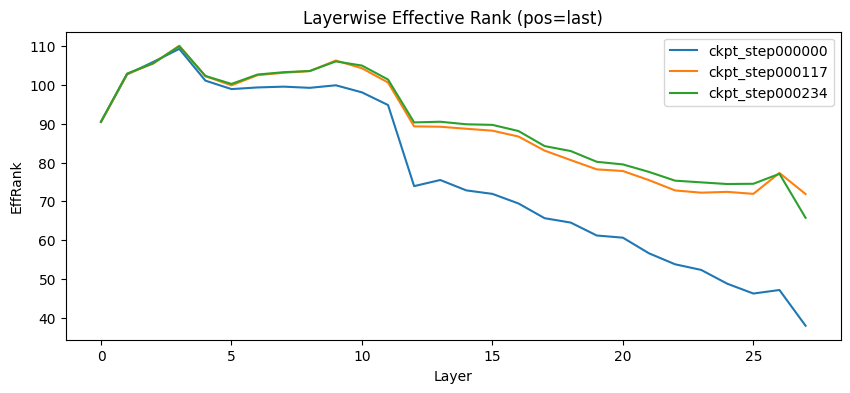

In [43]:
def layerwise_effrank(reps: np.ndarray, pos_idx: int) -> np.ndarray:
    L = reps.shape[0]
    out = np.zeros(L, dtype=np.float32)
    for l in range(L):
        X = reps[l, :, pos_idx, :]
        s = singular_values(X)
        out[l] = effective_rank_from_singulars(s)
    return out

effrank = {}
for f in rep_files:
    reps, _, ckpt = load_reps(f)
    effrank[ckpt] = layerwise_effrank(reps, pos_to_use)

plt.figure(figsize=(10,4))
for ckpt, curve in effrank.items():
    plt.plot(curve, label=ckpt)
plt.title(f"Layerwise Effective Rank (pos={pos_names[pos_to_use]})")
plt.xlabel("Layer")
plt.ylabel("EffRank")
plt.legend()
plt.show()

### α-ReQ curves (Rényi effective ranks)

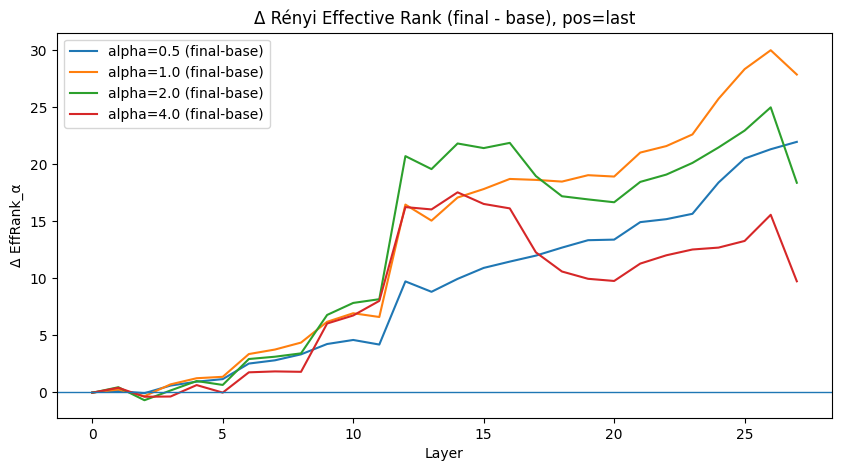

In [44]:
ALPHAS = [0.5, 1.0, 2.0, 4.0]

def layerwise_renyi(reps: np.ndarray, pos_idx: int, alpha: float) -> np.ndarray:
    L = reps.shape[0]
    out = np.zeros(L, dtype=np.float32)
    for l in range(L):
        X = reps[l, :, pos_idx, :]
        s = singular_values(X)
        out[l] = renyi_effective_rank(s, alpha=alpha)
    return out

# Compare base vs final for different alphas
base = base_reps
final = final_reps

plt.figure(figsize=(10,5))
for a in ALPHAS:
    bcurve = layerwise_renyi(base, pos_to_use, a)
    fcurve = layerwise_renyi(final, pos_to_use, a)
    plt.plot(fcurve - bcurve, label=f"alpha={a} (final-base)")
plt.axhline(0, linewidth=1)
plt.title(f"Δ Rényi Effective Rank (final - base), pos={pos_names[pos_to_use]}")
plt.xlabel("Layer")
plt.ylabel("Δ EffRank_α")
plt.legend()
plt.show()

## Behavioral “flip set” for mech-interp (base wrong → SFT correct)

Quick evaluator (extract final numeric answer)

In [45]:
@torch.no_grad()
def generate_final_answer(model, tokenizer, prompt: str, max_new_tokens=256):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        temperature=0.0,
        pad_token_id=tokenizer.eos_token_id,
    )
    text = tokenizer.decode(out[0], skip_special_tokens=True)

    # crude: grab last number-like span
    nums = re.findall(r"-?\d+(?:\.\d+)?", text.split("Assistant:")[-1])
    pred = nums[-1] if len(nums) > 0 else ""
    return pred, text

def eval_accuracy_for_ckpt(ckpt_dir: Path, tokenizer, eval_fmt, n=50):
    model = AutoModelForCausalLM.from_pretrained(
        str(ckpt_dir),
        torch_dtype=torch.float16,
        device_map="cuda",
        trust_remote_code=True,
    )
    model.config.use_cache = True
    model.eval()

    correct = []
    preds = []
    for i in range(n):
        prompt = eval_fmt[i]["prompt"]
        gt = eval_fmt[i]["final"]
        pred, full = generate_final_answer(model, tokenizer, prompt, max_new_tokens=256)
        ok = (pred.strip() == gt.strip())
        correct.append(ok)
        preds.append((pred, gt))
    return np.mean(correct), preds

Identify flip set

In [46]:
base_ckpt = CKPTS_TO_USE[0]
final_ckpt = CKPTS_TO_USE[-1]

tok = AutoTokenizer.from_pretrained(str(base_ckpt), use_fast=True, trust_remote_code=True)
if tok.pad_token is None: tok.pad_token = tok.eos_token

# Evaluate first 100 for speed
N_FLIP_SCAN = 100

def get_correct_mask(ckpt_dir):
    model = AutoModelForCausalLM.from_pretrained(
        str(ckpt_dir),
        torch_dtype=torch.float16,
        device_map="cuda",
        trust_remote_code=True,
    )
    model.eval()
    mask = []
    for i in range(N_FLIP_SCAN):
        pred, _ = generate_final_answer(model, tok, eval_fmt[i]["prompt"], max_new_tokens=256)
        mask.append(pred.strip() == eval_fmt[i]["final"].strip())
    return np.array(mask, dtype=bool)

base_ok = get_correct_mask(base_ckpt)
final_ok = get_correct_mask(final_ckpt)

flip = (~base_ok) & (final_ok)
flip_idx = np.where(flip)[0].tolist()

print("base acc:", base_ok.mean(), "final acc:", final_ok.mean())
print("flip count:", len(flip_idx), "flip idx:", flip_idx[:20])

The tokenizer you are loading from '/content/align-drift-sft/ckpt_step000000' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


base acc: 0.37 final acc: 0.51
flip count: 22 flip idx: [5, 10, 17, 26, 27, 28, 29, 36, 37, 41, 45, 50, 52, 53, 57, 61, 72, 73, 76, 78]


## Circuit-level / causal scaffold: Activation patching

In [47]:
def get_block_list(model):
    """
    Try common paths used by Qwen-like models.
    """
    candidates = [
        ("model.layers", lambda m: m.model.layers),
        ("transformer.h", lambda m: m.transformer.h),
        ("gpt_neox.layers", lambda m: m.gpt_neox.layers),
        ("layers", lambda m: m.layers),
    ]
    for name, fn in candidates:
        try:
            blocks = fn(model)
            if isinstance(blocks, (list, torch.nn.ModuleList)) and len(blocks) > 0:
                print("Using blocks:", name, "num_layers=", len(blocks))
                return blocks
        except Exception:
            pass
    raise RuntimeError("Could not locate transformer blocks. Inspect model.named_modules().")

### Cache hidden states for base & SFT (one example)

In [51]:
@torch.no_grad()
def forward_hidden_states(model, tokenizer, prompt: str, max_new_tokens=0):
    # Only prompt forward (no generation) for patching analysis
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model(**inputs, output_hidden_states=True)
    # hidden_states: tuple (emb, layer1..L) each [B,T,D]
    return inputs, out.hidden_states

def pick_patch_pos(inputs, tokenizer):
    # patch at last prompt token
    T = inputs["input_ids"].shape[1]
    return T - 1

### Activation patch hook (patch layer output)

In [52]:
def run_with_layer_patch(patch_pos: int, patch_vec: torch.Tensor):
    """
    Returns a forward hook that overwrites the hidden state at token position `patch_pos`
    with `patch_vec` (shape [D]) in the layer output.

    Works whether the module returns:
      - Tensor: [B, T, D]
      - Tuple:  (hidden_states, ...)
    """
    patch_vec = patch_vec.detach()

    def hook_fn(module, inp, out):
        if isinstance(out, tuple):
            h = out[0]
            rest = out[1:]
        else:
            h = out
            rest = None

        h2 = h.clone()
        h2[:, patch_pos, :] = patch_vec.unsqueeze(0).to(h2.device, dtype=h2.dtype)

        if rest is None:
            return h2
        return (h2,) + rest

    return hook_fn

## Layer sweep for a flip example (patching score proxy)

In [56]:
@torch.no_grad()
def answer_logprob(model, tokenizer, prompt: str, answer: str):
    """
    Compute log p(answer | prompt) under teacher forcing, token-level.
    """
    tok_p = tokenizer(prompt, add_special_tokens=False, return_tensors="pt")
    tok_a = tokenizer(answer, add_special_tokens=False, return_tensors="pt")

    input_ids = torch.cat([tok_p["input_ids"], tok_a["input_ids"]], dim=1).to(model.device)
    attn = torch.ones_like(input_ids).to(model.device)

    out = model(input_ids=input_ids, attention_mask=attn)
    logits = out.logits  # [1, T, V]

    # logprob of answer tokens at their positions (next-token prediction)
    a_len = tok_a["input_ids"].shape[1]
    # positions predicting answer: last a_len tokens correspond to next-token targets
    # targets are input_ids shifted by 1
    logp = torch.log_softmax(logits[:, :-1, :], dim=-1)  # [1,T-1,V]
    targets = input_ids[:, 1:]                           # [1,T-1]
    # get last a_len target positions
    lp = logp[0, -a_len:, :].gather(1, targets[0, -a_len:].unsqueeze(1)).sum()
    return float(lp.item())

@torch.no_grad()
def layer_patching_sweep(base_ckpt: Path, sft_ckpt: Path, tokenizer, prompt: str, gt_answer: str):
    base = AutoModelForCausalLM.from_pretrained(
        str(base_ckpt),
        torch_dtype=torch.float16,
        device_map="cuda",
        trust_remote_code=True
    )
    sft = AutoModelForCausalLM.from_pretrained(
        str(sft_ckpt),
        torch_dtype=torch.float16,
        device_map="cuda",
        trust_remote_code=True
    )
    base.eval(); sft.eval()
    base.config.use_cache = False
    sft.config.use_cache  = False

    base_blocks = get_block_list(base)
    sft_blocks  = get_block_list(sft)
    L = len(base_blocks)

    inputs, _ = forward_hidden_states(base, tokenizer, prompt)
    _, sft_hs = forward_hidden_states(sft, tokenizer, prompt)
    pos = pick_patch_pos(inputs, tokenizer)

    base_score = answer_logprob(base, tokenizer, prompt, gt_answer)

    scores = []
    for l in range(L):
        patch_vec = sft_hs[l+1][0, pos, :].detach()   # [D]

        hook = run_with_layer_patch(patch_pos=pos, patch_vec=patch_vec)
        handle = base_blocks[l].register_forward_hook(hook)

        patched_score = answer_logprob(base, tokenizer, prompt, gt_answer)
        scores.append(patched_score - base_score)

        handle.remove()

    return np.array(scores, dtype=np.float32)

### Run patch sweep on a few flip examples

Using blocks: model.layers num_layers= 28
Using blocks: model.layers num_layers= 28
Using blocks: model.layers num_layers= 28
Using blocks: model.layers num_layers= 28
Using blocks: model.layers num_layers= 28
Using blocks: model.layers num_layers= 28
Using blocks: model.layers num_layers= 28
Using blocks: model.layers num_layers= 28
Using blocks: model.layers num_layers= 28
Using blocks: model.layers num_layers= 28


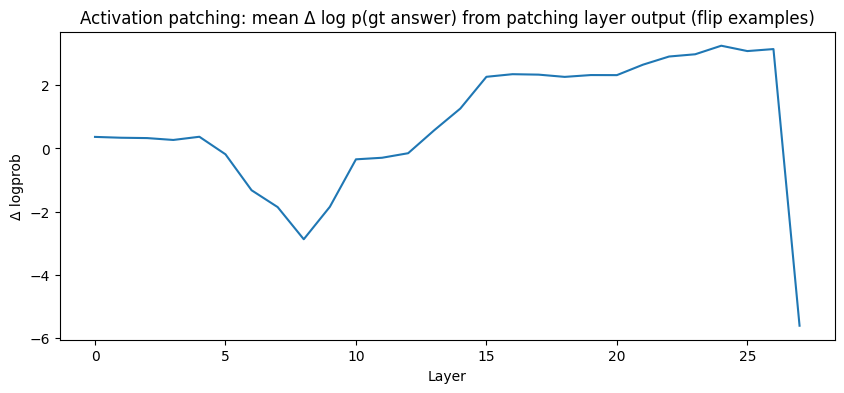

In [57]:
if len(flip_idx) > 0:
    test_ids = flip_idx[:5]
    all_scores = []
    for i in test_ids:
        prompt = eval_fmt[i]["prompt"]
        gt = eval_fmt[i]["final"]
        delta = layer_patching_sweep(base_ckpt, final_ckpt, tok, prompt, gt)
        all_scores.append(delta)

    all_scores = np.stack(all_scores, axis=0)  # [K, L]
    mean_delta = all_scores.mean(axis=0)

    plt.figure(figsize=(10,4))
    plt.plot(mean_delta)
    plt.title("Activation patching: mean Δ log p(gt answer) from patching layer output (flip examples)")
    plt.xlabel("Layer")
    plt.ylabel("Δ logprob")
    plt.show()
else:
    print("No flip examples found in scan. Increase N_FLIP_SCAN or train longer.")